# Topography at the inner core boundary

Without external motions in the solid inner core (convective instabilities or flows induced by external forces such as due to magnetic field), the topography at the inner core boundary (ICB) is set by the equilibrium between viscous relaxation of the topography and the freezing/melting at the ICB that induce a topography. 

Viscous relaxation tends to flatten the ICB, while building of the topography is due, for example, to lateral variation of growth rate. Lateral variations of the temperature in the outer core are considered of the order of $10^{-3}$ K (find a reference) because of the highly turbulent flow in the liquid metal. However, lateral variations of heat flux are considered larger. The large scale variations have in fact been proposed as the main driving forces for inner core flows in the case of no-convection (Yoshida, Deguen), giving velocities larger than any other proposed mechanisms for viscosities larger than $10^{14}$ Pa.s (Lasbleis). In this case, the degree 2 heat flux variation induces a degree 2 variation (TO DO : check degree 2?) in  the growth rate, which is viscously relaxed in the bulk of the inner core. As these studies focused on large scale flows in the bulk of the inner core, small scales variation of the heat flux were not considered. Given the turbulent flow in the outer core, small scales variations of the heat fluxes are in fact considered highly random, contrary to the equatorial/pole variations due to the organisation of the flow in the outer core in Taylor columns aligned with the rotation axis. 

Here, we proposed to estimate the topography induced by smal scale variations of the heat flux, considering that such variations are randomly determined by a Markoff process with a given correlation time. 

In [1]:
%matplotlib inline

import theano  #to generate and deal with lots of parallel path (ideal for looking at statistics!)
import theano.tensor as T
from theano.tensor.shared_randomstreams import RandomStreams
import numpy as np
import matplotlib.pyplot as plt
import time

## Examples for solving a stochastic equation : bistable genetic

This has been adapted from http://www.nehalemlabs.net/prototype/blog/2013/10/17/solving-stochastic-differential-equations-with-theano/

Define the ode function : dc/dt  = f(c, lambda) (c is a vector with m components, the number of samples chosen)

Here, f(c, lambda)= c^n/(c^n +k^n) - lambda c

### Class model, generic class for solving stochastic equations.
Define the schemes for integration (Euler and Runge Kutta order 4)

In [26]:
class Model():
    
    def __init__(self, seed = 31233):
        self.name = None
        self.srng = RandomStreams(seed=seed)
        self.rv_n = None #self.srng.normal(c.shape, std=0.05)
        self.num_samples = None # has to be add 
        self.dt0 = None #0.1
        self.total_time = None #10
        self.total_steps = None #int(total_time/dt0)
        self.c_initial_value = None
        
    def init_run(self, num_samples, dt0, total_time, c_initial_value):
        self.num_samples = num_samples
        self.dt0 = dt0
        self.total_time = total_time
        self.total_steps = int(total_time/dt0)
        self.c_initial_value = c_initial_value
        self.c0 = theano.shared(self.c_initial_value*np.ones(self.num_samples, dtype='float32'))
            #define symbolic variables
        self.dt = T.fscalar("dt")
        self.c = T.fvector("c")
        self.rv_n = self.srng.normal(self.c.shape, std=0.05) #not a global variable
        
    def evolve(self,c):
        raise NotImplementedError("to be defined in subclass")
                
    def euler(self,c, n, k, l, dt):
        return T.cast(c + dt*evolve(c, n, k, l) + T.sqrt(dt)*c*rv_n, 'float32')

    def rk4(self, c, dt):
        '''
        Adapted from
        http://people.sc.fsu.edu/~jburkardt/c_src/stochastic_rk/stochastic_rk.html
        '''
        a21 =   2.71644396264860
        a31 = - 6.95653259006152
        a32 =   0.78313689457981
        a41 =   0.0
        a42 =   0.48257353309214
        a43 =   0.26171080165848
        a51 =   0.47012396888046
        a52 =   0.36597075368373
        a53 =   0.08906615686702
        a54 =   0.07483912056879
 
        q1 =   2.12709852335625
        q2 =   2.73245878238737
        q3 =  11.22760917474960
        q4 =  13.36199560336697

        x1 = c
        k1 = dt * self.evolve(x1) + T.sqrt(dt) * c * self.rv_n

        x2 = x1 + a21 * k1
        k2 = dt * self.evolve(x2) + T.sqrt(dt) * c * self.rv_n

        x3 = x1 + a31 * k1 + a32 * k2
        k3 = dt * self.evolve(x3) + T.sqrt(dt) * c * self.rv_n

        x4 = x1 + a41 * k1 + a42 * k2
        k4 = dt * self.evolve(x4) + T.sqrt(dt) * c * self.rv_n

        return T.cast(x1 + a51 * k1 + a52 * k2 + a53 * k3 + a54 * k4, 'float32')
    
    
    def run(self):
       
        c = self.c
        dt = self.dt

        #create loop
        #first symbolic loop with everything
        (cout, updates) = theano.scan(fn=self.rk4,
                                 outputs_info=[c], #output shape
                                 non_sequences=[dt], #fixed parameters
                                 n_steps=self.total_steps)

        #compile it
        sim = theano.function(inputs=[dt], 
                               outputs=cout, 
                               givens={c:self.c0}, 
                               updates=updates, 
                               allow_input_downcast=True)

        print "running sim..."
        start = time.clock()
        cout = sim(self.dt0)
        diff = (time.clock() - start)
        print "done in", diff, "s at ", diff/model.num_samples, "s per path"
        
        self.cout = cout
        
    def plot_series(self):
        
        downsample_factor_t = int(0.1/self.dt0) #always show 10 points per time unit
        downsample_factor_p = int(self.num_samples/50)
        x = np.linspace(0, self.total_time, int(self.total_steps/downsample_factor_t))
        plt.subplot(211)
        plt.title(self.name)
        plt.plot(x, self.cout[::downsample_factor_t, ::downsample_factor_p])
        plt.subplot(212)
        bins = np.linspace(0, 1.2, 50)
        plt.hist(self.cout[int(1/self.dt0)], bins, alpha = 0.5, 
                    normed=True, histtype='bar',  
                    label=['Time one'])
        plt.hist(self.cout[int(2/self.dt0)], bins, alpha = 0.5, 
                    normed=True, histtype='bar',  
                    label=['Time two'])
        plt.hist(self.cout[-1], bins, alpha = 0.5, 
                    normed=True, histtype='bar',  
                    label=['Final time'])
        plt.legend()
        plt.show()

In [12]:
class BistableGenetic(Model):
    
    def __init__(self, n, k, l):
        Model.__init__(self)
        self.name = "Bistable genetic"
        self.n = n
        self.k = k
        self.l =l
        
    def evolve(self,c):
        return T.pow(c, self.n)/(T.pow(c, self.n)+T.pow(self.k,self.n)) - self.l*c


running sim...
done in 0.705971 s at  7.05971e-06 s per path


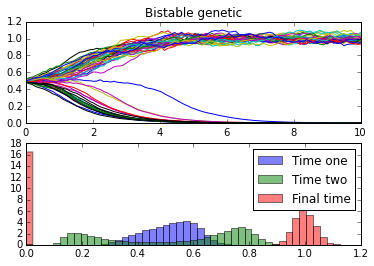

In [13]:
#random


#define numeric variables
num_samples = 100000
#c0 = theano.shared(0.5*np.ones(num_samples, dtype='float32'))
n0 = 6
k0 = 0.5
l0 = 1/(1+np.power(k0, n0))
dt0 = 0.1
total_time = 10
total_steps = int(total_time/dt0)


model = BistableGenetic(n0, k0, l0)
model.init_run(num_samples, dt0, total_time, 0.5)


model.run()
model.plot_series()

Same solver can solve different equations, by adding subclasses with different function evolve()

## Random walk

### Definition of the subclass

In [14]:
class RandomWalk(Model):
    def __init__(self):
        Model.__init__(self)
        self.name = "Random Walk"
    def evolve(self,c):
        return 0.*c

### Example of resolution

In [17]:
#define numeric variables
c_initial_value = 1.
num_samples = 100
dt0 = 0.1
total_time = 100
model_run = RandomWalk()
model_run.init_run(num_samples, dt0, total_time, c_initial_value)

running sim...
done in 0.032886 s at  3.2886e-07 s per path


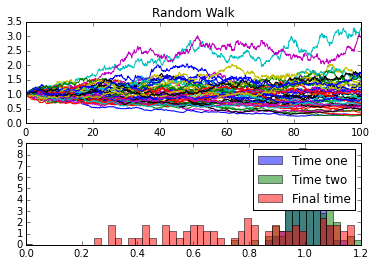

In [18]:
model_run.run()
model_run.plot_series()# run the simulation

## Random walk with correlation time

In [20]:
class RandomCorrelatedWalk(Model):
    def __init__(self, tau):
        Model.__init__(self)
        self.name = "Random Correlated Walk"
        self.tau = tau
    def evolve(self,c):
        return -c/tau

In [24]:
c_initial_value = 1.
num_samples = 100
dt0 = 0.1
total_time = 100
tau=100.
model = RandomCorrelatedWalk(tau)
model.init_run(num_samples, dt0, total_time, c_initial_value)

running sim...
done in 0.038478 s at  0.00038478 s per path


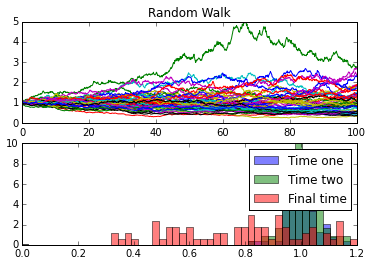

In [25]:
model_run.run()
model_run.plot_series()# run the simulation